<a href="https://colab.research.google.com/github/StanleyLiangYork/TensorFlow_For_Image/blob/master/image_style_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1 - Problem Statement

Neural Style Transfer (NST) is one of the most fun techniques in deep learning. As seen below, it merges two images, namely: a **"content" image (C) and a "style" image (S), to create a "generated" image (G**). 

The generated image G combines the "content" of the image C with the "style" of image S. 

In [0]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
# from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
import pprint
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model

In [0]:
import os

if not os.path.exists('images.zip'):
    !gsutil cp gs://pet-detect-239118/images.zip ./images.zip

In [0]:
import zipfile

with zipfile.ZipFile('images.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

In [0]:
def tensor_to_image(tensor):
  tensor = tensor*255 # rescale to [0, 255]
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [0]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3, dtype=tf.dtypes.float32)
  img = tf.image.convert_image_dtype(img, tf.float32)
  # cast int32 to floast32, remove the last i.e. channel dim
  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape) # get the max dim (height or width)
  scale = max_dim / long_dim # scaler to the max dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :] # add the image number axis
  return img

In [0]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

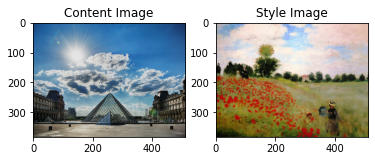

In [10]:
content_image = load_img('./images/louvre.jpg')
style_image = load_img('./images/monet.jpg')
# pixel value [0, 1]

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')
# plt.axis('off')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')
# plt.axis('off')

In [11]:
# upscale the pixel to [0,255]
x = tf.keras.applications.vgg19.preprocess_input(content_image*255) 
x = tf.image.resize(x, (224, 224))
# load the pretrained VGG19 with classification layers
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
# encode the 1000 class probabilities
prediction_probabilities.shape

TensorShape([1, 1000])

In [12]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
for _, label, prob in predicted_top_5:
  print(f'{label}: {prob}')

palace: 0.36000797152519226
suspension_bridge: 0.22193117439746857
castle: 0.09854665398597717
monastery: 0.07115033268928528
pier: 0.05686996504664421


In [13]:
x = tf.keras.applications.vgg19.preprocess_input(style_image*255) 
x = tf.image.resize(x, (224, 224))
prediction_probabilities = vgg(x)
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
for _, label, prob in predicted_top_5:
  print(f'{label}: {prob}')

parachute: 0.2731701731681824
balloon: 0.16641531884670258
bison: 0.08350596576929092
water_buffalo: 0.07193811982870102
ox: 0.035281311720609665


In [14]:
# load the pretrained VGG19 weights without the classification layers
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)


input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [15]:
# select the layers for the activations
# for content, higher layers, for style, lower layers

content_layers = ['block5_conv2'] 
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
print(num_content_layers)
num_style_layers = len(style_layers)
print(num_style_layers)

1
5


# download the vgg19 without the classifier

In [0]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  # single input with many output of activation
  # vgg.get_layer().output let the input image go through the network from the input
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs) # input-output pairs
  return model

## Visualize the style activations

block1_conv1
  shape:  (1, 384, 512, 64)
  min:  0.0
  max:  823.3103
  mean:  29.326002



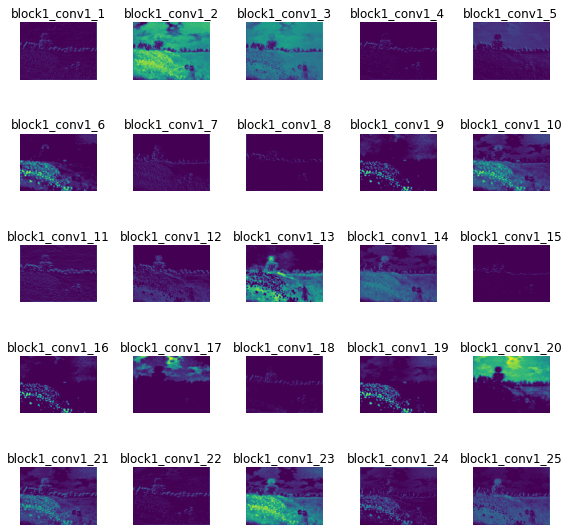

block2_conv1
  shape:  (1, 192, 256, 128)
  min:  0.0
  max:  2902.3857
  mean:  144.7163



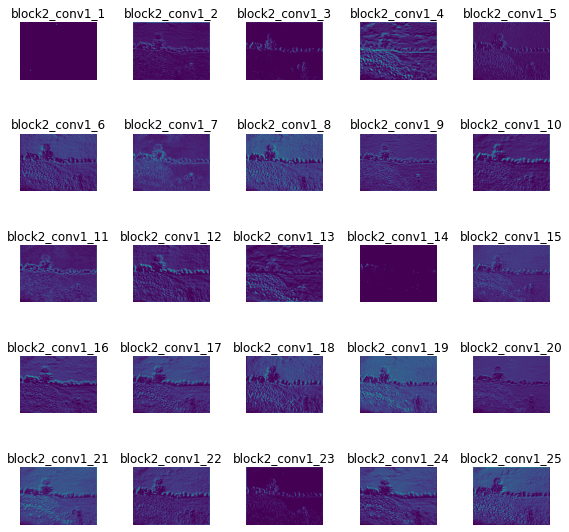

block3_conv1
  shape:  (1, 96, 128, 256)
  min:  0.0
  max:  8516.311
  mean:  120.36382



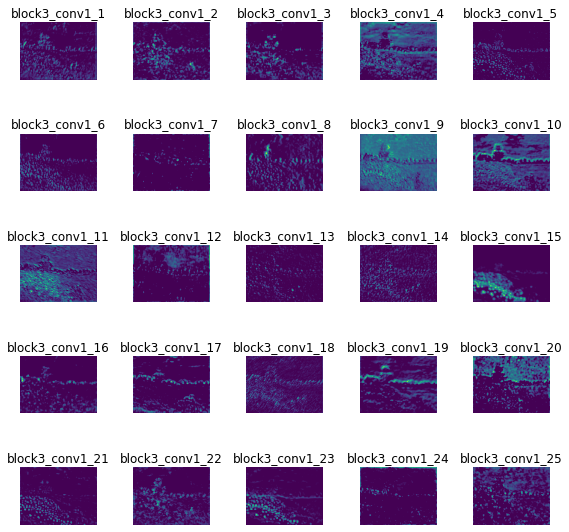

block4_conv1
  shape:  (1, 48, 64, 512)
  min:  0.0
  max:  14647.193
  mean:  481.8312



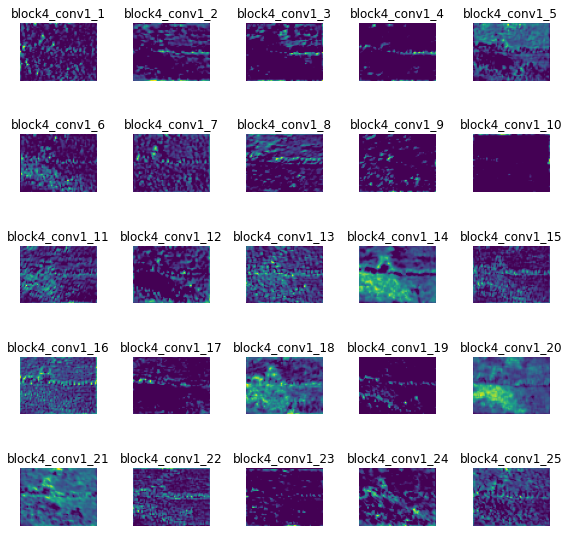

block5_conv1
  shape:  (1, 24, 32, 512)
  min:  0.0
  max:  2125.3857
  mean:  31.24582



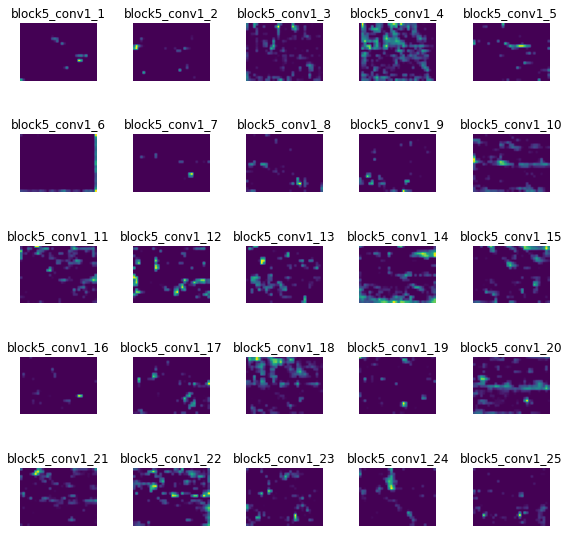

In [17]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()
  output = np.squeeze(output, axis=0)
  plt.figure(figsize=(8,8))
  for i in range(25):
    plt.subplot(5,5, i+1)
    plt.axis('off')
    plt.title(name+'_'+str(i+1))
    plt.imshow(output[:,:,i])
  plt.tight_layout()
  plt.show() 


## Visualize the content activations 

block5_conv2
  shape:  (24, 32, 512)
  min:  0.0
  max:  1441.92
  mean:  16.591713



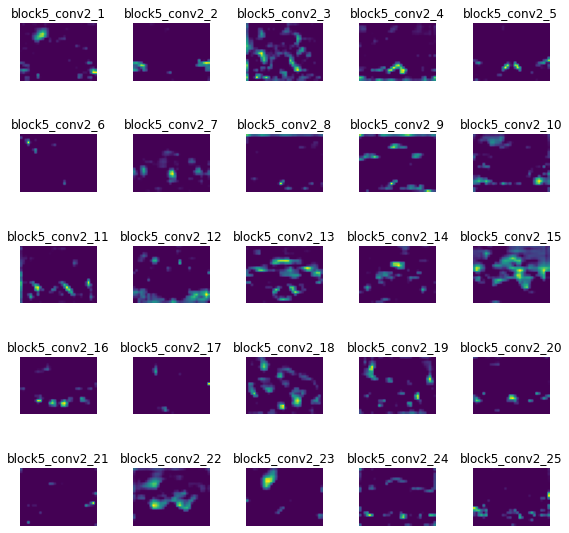

In [18]:
content_extractor = vgg_layers(content_layers)
content_outputs = content_extractor(content_image*255)

#Look at the statistics of each layer's output
for name, output in zip(content_layers, content_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()
  
  plt.figure(figsize=(8,8))
  for i in range(25):
    plt.subplot(5,5, i+1)
    plt.axis('off')
    plt.title(name+'_'+str(i+1))
    plt.imshow(output[:,:,i])
  plt.tight_layout()
  plt.show()

##Calculate the style
Calculate a Gram matrix that includes this information by taking the outer product of the feature vector with itself at each location, and averaging that outer product over all locations. This Gram matrix can be calculated for a particular layer as:
#### Gram matrix
* The style matrix is also called a "Gram matrix." 
* In linear algebra, the Gram matrix G of a set of vectors $(v_{1},\dots ,v_{n})$ is the matrix of dot products, whose entries are ${\displaystyle G_{ij} = v_{i}^T v_{j} = np.dot(v_{i}, v_{j})  }$. 
* In other words, $G_{ij}$ compares how similar $v_i$ is to $v_j$: If they are highly similar, you would expect them to have a large dot product, and thus for $G_{ij}$ to be large. 
#### Compute $G_{gram}$
In Neural Style Transfer (NST), you can compute the Style matrix by multiplying the "unrolled" filter matrix with its transpose:

$$\mathbf{G}_{gram} = \mathbf{A}_{unrolled} \mathbf{A}_{unrolled}^T$$

#### $G_{(gram)i,j}$: correlation
The result is a matrix of dimension $(n_C,n_C)$ where $n_C$ is the number of filters (channels). The value $G_{(gram)i,j}$ measures how similar the activations of filter $i$ are to the activations of filter $j$. 

#### $G_{(gram),i,i}$: prevalence of patterns or textures
* The diagonal elements $G_{(gram)ii}$ measure how "active" a filter $i$ is. 
* For example, suppose filter $i$ is detecting vertical textures in the image. Then $G_{(gram)ii}$ measures how common  vertical textures are in the image as a whole.
* If $G_{(gram)ii}$ is large, this means that the image has a lot of vertical texture. 


By capturing the prevalence of different types of features ($G_{(gram)ii}$), as well as how much different features occur together ($G_{(gram)ij}$), the Style matrix $G_{gram}$ measures the style of an image.

In [0]:
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    
    result = tf.matmul(A, A, transpose_b=True)
    input_shape = tf.shape(A)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    # evenly assign weights to each output activation
    GA = result/(num_locations)
    
    return GA

Build a model that returns the style and content tensors

In [0]:
class StyleContentModel(tf.keras.models.Model):
  # initiate an instance of the model
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    # concatenate the activations layers style (5 layers) + content (1 layer)
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  # call a class instance as a function
  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    # activation outputs - first the 5 style activations, then the 1 content activation
    outputs = self.vgg(preprocessed_input)
    # assign the outputs back to style output and content output
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    # calculate the gram matrices of style
    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    # put the activations into a dictionary structure
    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}

In [0]:
content_layers = ['block5_conv2'] 
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

# initiate the extractor instance
extractor = StyleContentModel(style_layers, content_layers)

Styles:
   block1_conv1
    shape:  (1, 384, 512, 512)
    min:  0.0
    max:  9.296045
    mean:  0.56669015



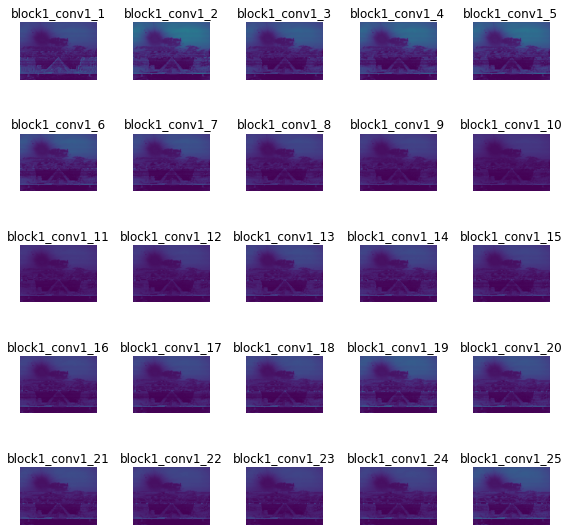

   block2_conv1
    shape:  (1, 192, 256, 256)
    min:  1.1987292
    max:  1453.8247
    mean:  56.99632



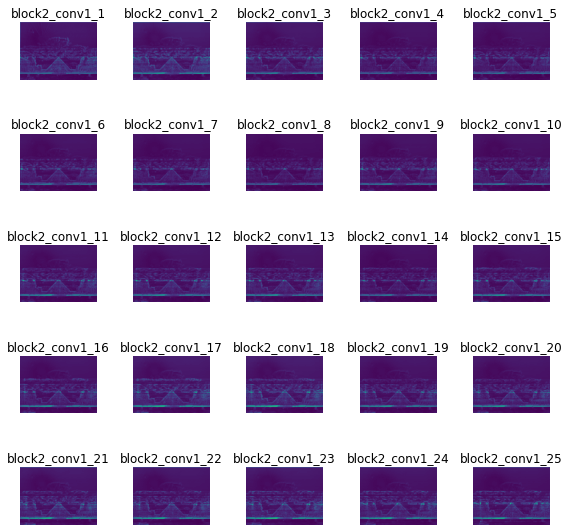

   block3_conv1
    shape:  (1, 96, 128, 128)
    min:  18.241932
    max:  9312.2705
    mean:  481.41714



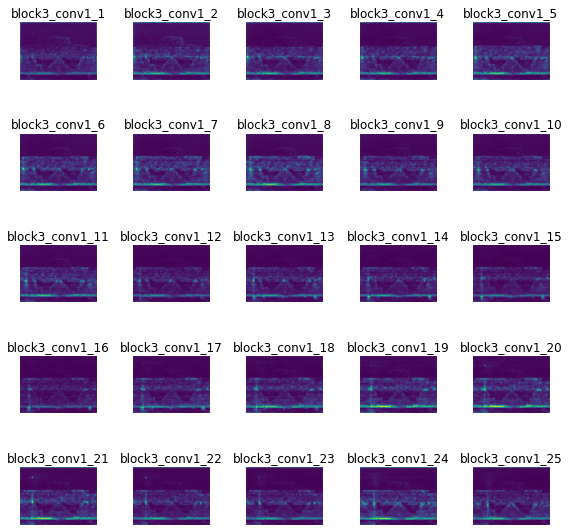

   block4_conv1
    shape:  (1, 48, 64, 64)
    min:  6061.25
    max:  559510.6
    mean:  55777.25



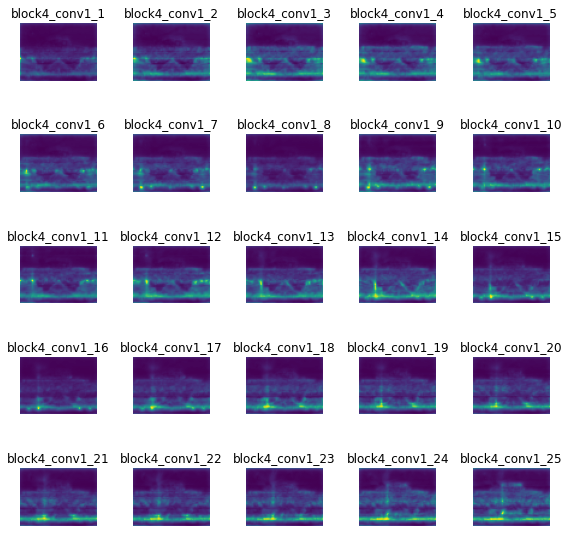

   block5_conv1
    shape:  (1, 24, 32, 32)
    min:  202.49745
    max:  40480.652
    mean:  3069.9836



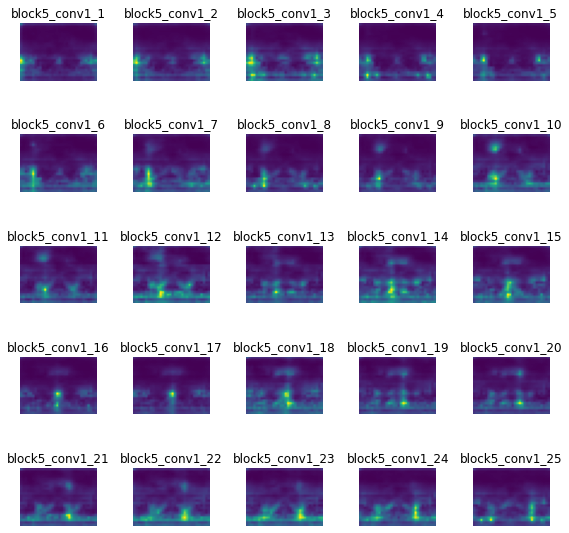

Contents:
   block5_conv2
    shape:  (1, 24, 32, 512)
    min:  0.0
    max:  1098.3221
    mean:  14.550507


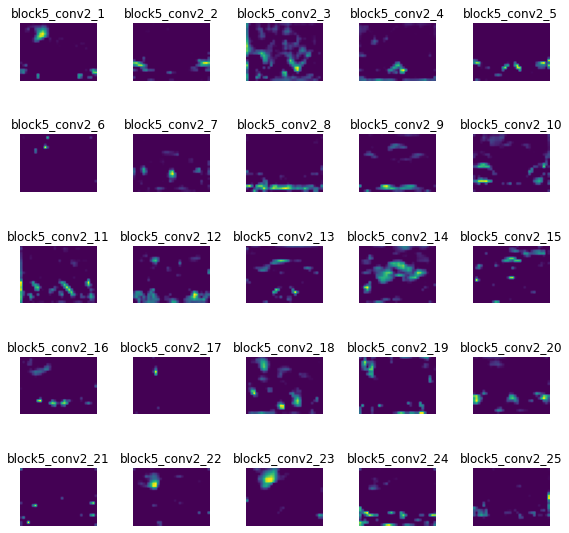

In [22]:
# input an image that will go through all layers 
results = extractor(tf.constant(content_image))
print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()
  output = np.squeeze(output, axis=0)
  plt.figure(figsize=(8,8))
  for i in range(25):
    plt.subplot(5,5, i+1)
    plt.axis('off')
    plt.title(name+'_'+str(i+1))
    plt.imshow(output[:,:,i])
  plt.tight_layout()
  plt.show()

print('Contents:')
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  output = np.squeeze(output, axis=0)
  plt.figure(figsize=(8,8))
  for i in range(25):
    plt.subplot(5,5, i+1)
    plt.axis('off')
    plt.title(name+'_'+str(i+1))
    plt.imshow(output[:,:,i])
  plt.tight_layout()
  plt.show()



## Run gradient descent

# Assign the style layers and the content layer to the extractor

Define a tf.Variable to contain the image to optimize. it muse have the same shape as the content image

In [0]:
image = tf.Variable(content_image) # load the content image as the start point of generated image (G)

# scale the pixel values to [0, 1]
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [0]:
opt = tf.optimizers.Adam(learning_rate=0.01, beta_1=0.99, epsilon=1e-1)

In [0]:
style_weight=0.2
content_weight=0.8

## Define the loss function - using MSE

In [0]:
def style_content_loss(outputs, style_targets, content_targets):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    num_content_layers = 1
    num_style_layers = 5
    # tf.math.add_n  waits for all of its inputs to be ready before beginning to sum up them.
    # get the MSE between the generated image (G) and the style image (S)
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    # get the MSE between the generated image (G) and the content image (C)
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [0]:
@tf.function()  # Compiles a function into a callable TensorFlow graph
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs, style_targets, content_targets)
  # get the gradient
  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  # assign the new value of the newly generated image
  image.assign(clip_0_1(image))

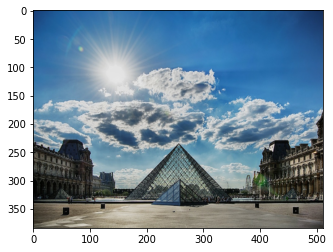

In [91]:
import PIL

# get the content activations from the one content layer
content_targets = extractor(content_image)['content']
show_img = tensor_to_image(image)
plt.imshow(show_img)

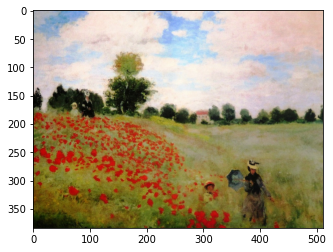

In [92]:
# get the activations from the five style layers
style_targets = extractor(style_image)['style']
show_img = tensor_to_image(style_image)
plt.imshow(show_img)

(1, 384, 512, 3)


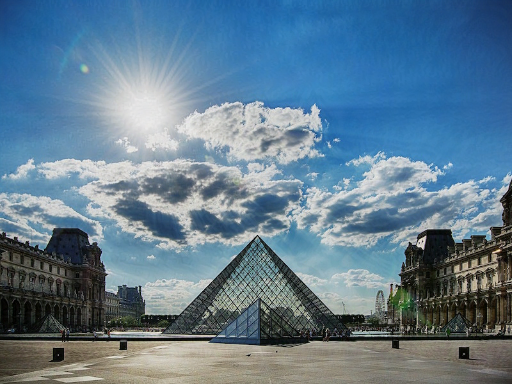

In [93]:
import PIL
train_step(image)
train_step(image)
train_step(image)
print(image.shape)
tensor_to_image(image)

Train epoch: 5


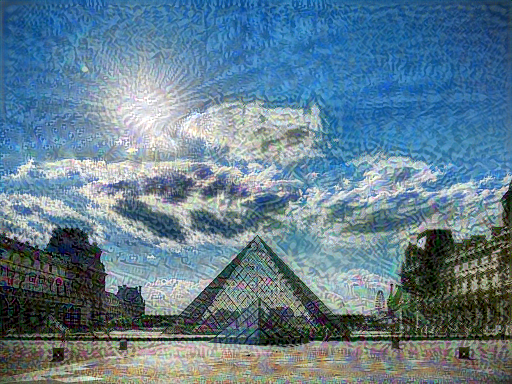

Total time: 1.4


In [94]:
import IPython.display as display
import time


start = time.time()

epochs = 5
steps_per_epoch = 5

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  print("Train epoch: {}".format(n+1))
  

display.display(tensor_to_image(image))
end = time.time()
print("Total time: {:.1f}".format(end-start))


In [0]:
from tensorflow.keras.preprocessing.image import save_img
img_array = image.numpy()
img_array = np.squeeze(img_array, axis=0)
img_array.shape
save_img('generated_image.jpg', img_array)

## Total variation loss
One downside to the basic style learning is that it produces a lot of high frequency artifacts. Decrease these using an explicit regularization term on the high frequency components of the image. In style transfer, this is often called the total variation loss:

In [0]:
def high_pass_x_y(image):
  x_var = image[:,:,1:,:] - image[:,:,:-1,:]  # remove the horizontal pixel value
  y_var = image[:,1:,:,:] - image[:,:-1,:,:]  # remove the vertical pixel value

  return x_var, y_var

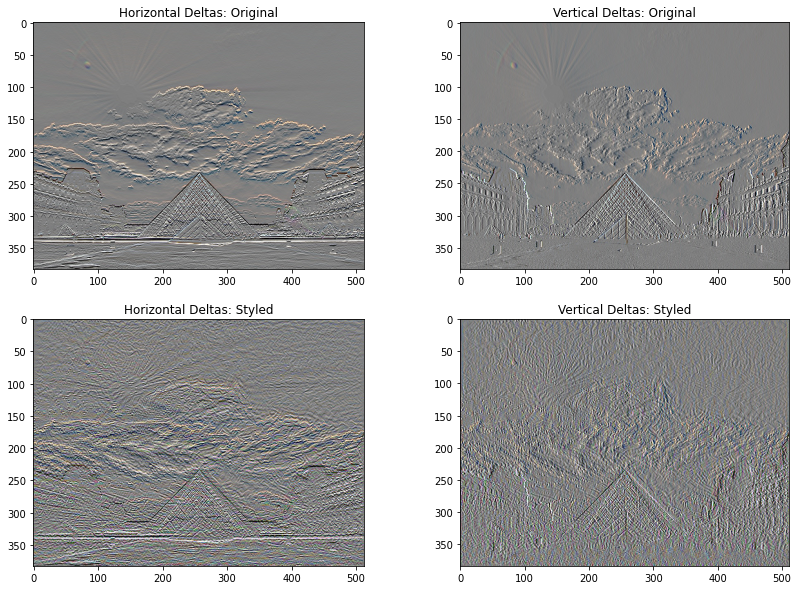

In [97]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2,2,2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2,2,3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2,2,4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

Use the Sobel edge detector to highlight the artifacts

(1, 384, 512, 3, 2)


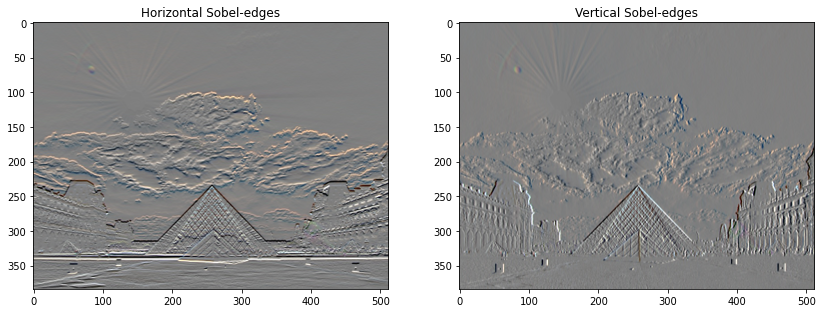

In [98]:
plt.figure(figsize=(14,10))

sobel = tf.image.sobel_edges(content_image)
print(sobel.numpy().shape)
plt.subplot(1,2,1)
imshow(clip_0_1(sobel[...,0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1,2,2)
imshow(clip_0_1(sobel[...,1]/4+0.5), "Vertical Sobel-edges")

In [99]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

total_loss = total_variation_loss(image).numpy()
print(total_loss)

78736.14


In [100]:
tf.image.total_variation(image).numpy()

array([78736.14], dtype=float32)

Add the regularization term for the training process

In [0]:
total_variation_weight=30

@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs, style_targets, content_targets)
    # add the regularization term to the loss
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [0]:
image = tf.Variable(content_image)


Train epoch: 5


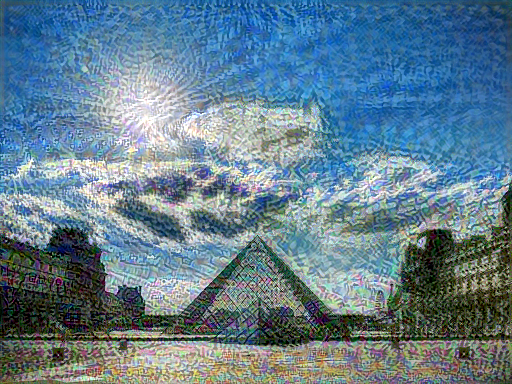

Total time: 4.4


In [103]:
import time
start = time.time()
content_targets = extractor(content_image)['content']
style_targets = extractor(style_image)['style']

epochs = 5
steps_per_epoch = 10

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  print("Train epoch: {}".format(n+1))

display.display(tensor_to_image(image))

end = time.time()
print("Total time: {:.1f}".format(end-start))

In [0]:
file_name = 'stylized_image.png'
tensor_to_image(image).save(file_name)

In [0]:
filename = '/content/images/louvre.jpg'
photo = load_img(filename)
imshow(photo)
plt.axis('off')
img = img_to_array(photo, dtype='uint8')
print(img.shape)

TypeError: ignored

## 2 - Transfer Learning

Neural Style Transfer (NST) uses a previously trained convolutional network, and builds on top of that. The idea of using a network trained on a different task and applying it to a new task is called transfer learning. <p>
We load the pretrained VGG-19 model from tensorflow

## 3 - Neural Style Transfer (NST)

We will build the Neural Style Transfer (NST) algorithm in three steps:

- Build the content cost function $J_{content}(C,G)$
- Build the style cost function $J_{style}(S,G)$
- Put it together to get $J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$. 

### 3.1 - Computing the content cost

In our running example, the content image C will be the picture of the Louvre Museum in Paris. Run the code below to see a picture of the Louvre.

** 3.1.1 - Make generated image G match the content of image C**

#### Shallower versus deeper layers
* The shallower layers of a ConvNet tend to detect lower-level features such as edges and simple textures.
* The deeper layers tend to detect higher-level features such as more complex textures as well as object classes. 

#### Choose a "middle" activation layer $a^{[l]}$
We would like the "generated" image G to have similar content as the input image C. Suppose you have chosen some layer's activations to represent the content of an image. 
* In practice, you'll get the most visually pleasing results if you choose a layer in the **middle** of the network--neither too shallow nor too deep. 
* (After you have finished this exercise, feel free to come back and experiment with using different layers, to see how the results vary.)

#### Forward propagate image "C"
* Set the image C as the input to the pretrained VGG network, and run forward propagation.  
* Let $a^{(C)}$ be the hidden layer activations in the layer you had chosen. (In lecture, we had written this as $a^{[l](C)}$, but here we'll drop the superscript $[l]$ to simplify the notation.) This will be an $n_H \times n_W \times n_C$ tensor.

#### Forward propagate image "G"
* Repeat this process with the image G: Set G as the input, and run forward progation. 
* Let $a^{(G)}$ be the corresponding hidden layer activation. 

#### Content Cost Function $J_{content}(C,G)$
We will define the content cost function as:

$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2\tag{1} $$

* Here, $n_H, n_W$ and $n_C$ are the height, width and number of channels of the hidden layer you have chosen, and appear in a normalization term in the cost. 
* For clarity, note that $a^{(C)}$ and $a^{(G)}$ are the 3D volumes corresponding to a hidden layer's activations. 
* In order to compute the cost $J_{content}(C,G)$, it might also be convenient to unroll these 3D volumes into a 2D matrix, as shown below.
* Technically this unrolling step isn't needed to compute $J_{content}$, but it will be good practice for when you do need to carry out a similar operation later for computing the style cost $J_{style}$.

**Instructions**: The 3 steps to implement this function are:
1. Retrieve dimensions from `a_G`: 
    - To retrieve dimensions from a tensor `X`, use: `X.get_shape().as_list()`
2. Unroll `a_C` and `a_G` as explained in the picture above
    - You'll likey want to use these functions: [tf.transpose](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/transpose) and [tf.reshape](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/reshape).
3. Compute the content cost:
    - You'll likely want to use these functions: [tf.reduce_sum](https://www.tensorflow.org/api_docs/python/tf/reduce_sum), [tf.square](https://www.tensorflow.org/api_docs/python/tf/square) and [tf.subtract](https://www.tensorflow.org/api_docs/python/tf/subtract).
    
    
#### Additional Hints for "Unrolling"
* To unroll the tensor, we want the shape to change from $(m,n_H,n_W,n_C)$ to $(m, n_H \times n_W, n_C)$.
* `tf.reshape(tensor, shape)` takes a list of integers that represent the desired output shape.
* For the `shape` parameter, a `-1` tells the function to choose the correct dimension size so that the output tensor still contains all the values of the original tensor.
* So tf.reshape(a_C, shape=[m, n_H * n_W, n_C]) gives the same result as tf.reshape(a_C, shape=[m, -1, n_C]).
* If you prefer to re-order the dimensions, you can use `tf.transpose(tensor, perm)`, where `perm` is a list of integers containing the original index of the dimensions. 
* For example, `tf.transpose(a_C, perm=[0,3,1,2])` changes the dimensions from $(m, n_H, n_W, n_C)$ to $(m, n_C, n_H, n_W)$.
* There is more than one way to unroll the tensors.
* Notice that it's not necessary to use tf.transpose to 'unroll' the tensors in this case but this is a useful function to practice and understand for other situations that you'll encounter.

In [0]:
# GRADED FUNCTION: compute_content_cost

def compute_content_cost(a_C, a_G):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape a_C and a_G (≈2 lines)
    a_C_unrolled = tf.reshape(a_C, shape=[m, n_H * n_W, n_C]) 
    a_G_unrolled = tf.reshape(a_G, shape=[m, -1, n_C])
    
    # compute the cost with tensorflow (≈1 line)
    J_content = 1 / (4 * n_H * n_W * n_C) * tf.reduce_sum((a_C - a_G)**2)
    
    return J_content

Test the loss function

In [0]:
tf.random.set_seed(1)
a_C = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
a_G = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
J_content = compute_content_cost(a_C, a_G)
print(f'J_content = {J_content.numpy()}')


J_content = 7.056877136230469


#### What you should remember
- The content cost takes a hidden layer activation of the neural network, and measures how different $a^{(C)}$ and $a^{(G)}$ are. 
- When we minimize the content cost later, this will help make sure $G$ has similar content as $C$.

### 3.2.1 - Style matrix

#### Gram matrix
* The style matrix is also called a "Gram matrix." 
* In linear algebra, the Gram matrix G of a set of vectors $(v_{1},\dots ,v_{n})$ is the matrix of dot products, whose entries are ${\displaystyle G_{ij} = v_{i}^T v_{j} = np.dot(v_{i}, v_{j})  }$. 
* In other words, $G_{ij}$ compares how similar $v_i$ is to $v_j$: If they are highly similar, you would expect them to have a large dot product, and thus for $G_{ij}$ to be large. 

#### Two meanings of the variable $G$
* Note that there is an unfortunate collision in the variable names used here. We are following common terminology used in the literature. 
* $G$ is used to denote the Style matrix (or Gram matrix) 
* $G$ also denotes the generated image. 
* For this assignment, we will use $G_{gram}$ to refer to the Gram matrix, and $G$ to denote the generated image.

#### Compute $G_{gram}$
In Neural Style Transfer (NST), you can compute the Style matrix by multiplying the "unrolled" filter matrix with its transpose:

$$\mathbf{G}_{gram} = \mathbf{A}_{unrolled} \mathbf{A}_{unrolled}^T$$

#### $G_{(gram)i,j}$: correlation
The result is a matrix of dimension $(n_C,n_C)$ where $n_C$ is the number of filters (channels). The value $G_{(gram)i,j}$ measures how similar the activations of filter $i$ are to the activations of filter $j$. 

#### $G_{(gram),i,i}$: prevalence of patterns or textures
* The diagonal elements $G_{(gram)ii}$ measure how "active" a filter $i$ is. 
* For example, suppose filter $i$ is detecting vertical textures in the image. Then $G_{(gram)ii}$ measures how common  vertical textures are in the image as a whole.
* If $G_{(gram)ii}$ is large, this means that the image has a lot of vertical texture. 


By capturing the prevalence of different types of features ($G_{(gram)ii}$), as well as how much different features occur together ($G_{(gram)ij}$), the Style matrix $G_{gram}$ measures the style of an image.

### 3.2.2 - Style cost

Your goal will be to minimize the distance between the Gram matrix of the "style" image S and the gram matrix of the "generated" image G. 
* For now, we are using only a single hidden layer $a^{[l]}$.  
* The corresponding style cost for this layer is defined as: 

$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{(gram)i,j} - G^{(G)}_{(gram)i,j})^2\tag{2} $$

* $G_{gram}^{(S)}$ Gram matrix of the "style" image.
* $G_{gram}^{(G)}$ Gram matrix of the "generated" image.
* Remember, this cost is computed using the hidden layer activations for a particular hidden layer in the network $a^{[l]}$

### 3.2.3 Style Weights

* So far you have captured the style from only one layer. 
* We'll get better results if we "merge" style costs from several different layers. 
* Each layer will be given weights ($\lambda^{[l]}$) that reflect how much each layer will contribute to the style.
* After completing this exercise, feel free to come back and experiment with different weights to see how it changes the generated image $G$.
* By default, we'll give each layer equal weight, and the weights add up to 1.  ($\sum_{l}^L\lambda^{[l]} = 1$)

You can combine the style costs for different layers as follows:

$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$

where the values for $\lambda^{[l]}$ are given in `STYLE_LAYERS`. 

## Description of compute_style_cost
For each layer:

Select the activation (the output tensor) of the current layer.
Get the style of the style image "S" from the current layer.
Get the style of the generated image "G" from the current layer.
Compute the "style cost" for the current layer
Add the weighted style cost to the overall style cost (J_style)

In [0]:
def compute_style_cost(model, STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    model -- our tensorflow model
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # initialize the overall style cost
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        # Select the output tensor of the currently selected layer
        out = model.get_layer(name=layer_name)

        # Set a_S to be the hidden layer activation from the layer we have selected, by running the session on out
        a_S = out

        # Set a_G to be the hidden layer activation from same layer. Here, a_G references model[layer_name] 
        # and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
        # when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
        a_G = out
        
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        # Add coeff * J_style_layer of this layer to overall style cost
        J_style += coeff * J_style_layer

    return J_style

### 3.3 - Defining the total cost to optimize
Finally, let's create a cost function that minimizes both the style and the content cost. The formula is: 

$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$

In [0]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    
    ### START CODE HERE ### (≈1 line)
    J = alpha * J_content + beta * J_style
    ### END CODE HERE ###
    
    return J

## 4 - Solving the optimization problem
1. Create an Interactive Session
2. Load the content image 
3. Load the style image
4. Randomly initialize the image to be generated 
5. Load the VGG19 model
7. Build the TensorFlow graph:
    - Run the content image through the VGG19 model and compute the content cost
    - Run the style image through the VGG19 model and compute the style cost
    - Compute the total cost
    - Define the optimizer and the learning rate
8. Initialize the TensorFlow graph and run it for a large number of iterations, updating the generated image at every step.

#### Generated image correlated with content image
Now, we initialize the "generated" image as a noisy image created from the content_image.

* The generated image is slightly correlated with the content image.
* By initializing the pixels of the generated image to be mostly noise but slightly correlated with the content image, this will help the content of the "generated" image more rapidly match the content of the "content" image. 

In [0]:
def generate_noise_image(content_image, noise_ratio = 0.6):
    """
    Generates a noisy image by adding random noise to the content_image
    """
    
    # Generate a random noise_image
    noise_image = np.random.uniform(-20, 20, (1, 300, 400, 3)).astype('float32')
    
    # Set the input_image to be a weighted average of the content_image and a noise_image
    input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)
    
    return input_image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 300, 400, 3)


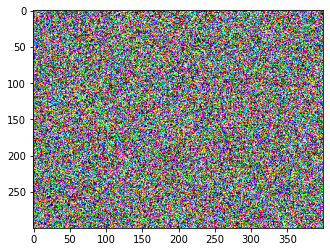

In [0]:
noise_image = np.random.uniform(-20, 20, (1, 300, 400, 3)).astype('float32')
print(noise_image.shape)
plt.imshow(noise_image[0])

#### Load pre-trained VGG19 model

In [0]:
model = VGG19(input_shape=(300,400,3),include_top=False, weights='imagenet')

Get the activation of layer conv4_2

In [0]:
def compute_content_cost(a_C, a_G):   
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape a_C and a_G (≈2 lines)
    a_C_unrolled = tf.reshape(a_C, shape=[m, n_H * n_W, n_C]) 
    a_G_unrolled = tf.reshape(a_G, shape=[m, -1, n_C])
    
    # compute the cost with tensorflow (≈1 line)
    J_content = 1 / (4 * n_H * n_W * n_C) * tf.reduce_sum((a_C - a_G)**2)
    
    return J_content


# Select the output tensor of layer conv4_2
model_conv4_2 = Model(inputs=model.input, outputs=model.get_layer('block4_conv2').output)

# Select the output tensor of layer conv4_2
out_C = model_conv4_2.predict(content_image)
out_C = tf.convert_to_tensor(out_C)
# out = model_conv4_2
# Set a_C to be the hidden layer activation from layer conv4_2
a_C = out_C

# Set a_G to be the hidden layer activation from same layer. 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that with G as input.
out_G = model_conv4_2.predict(noise_image)
out_G = tf.convert_to_tensor(out_G)
a_G = out_G

# Compute the content cost
J_content = compute_content_cost(a_C, a_G)
print(J_content)


tf.Tensor(104395.28, shape=(), dtype=float32)


###Style cost

In [0]:
def compute_style_cost(model, STYLE_LAYERS, S_img, G_img):
    # initialize the overall style cost
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        # Select the output tensor of the currently selected layer
        layer_activation = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
        out_S = layer_activation.predict(S_img)
        a_S = tf.convert_to_tensor(out_S)

        # Set a_G to be the hidden layer activation from same layer. Here, a_G references model[layer_name] 
        # and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
        # when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
        out_G = layer_activation.predict(G_img)
        a_G = tf.convert_to_tensor(out_G)
        
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        # Add coeff * J_style_layer of this layer to overall style cost
        J_style += coeff * J_style_layer

    return J_style



STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)]



J_style = compute_style_cost(model, STYLE_LAYERS, style_image, noise_image)
print(J_style)

tf.Tensor(5264430000.0, shape=(), dtype=float32)


###total cost
* Use `alpha = 10` and `beta = 40`.